# ChainerUI で学習経過を可視化

ChainerUI は Chainer で実験中の訓練ログの可視化や実験管理機能を追加するパッケージです。  
詳細な ChainerUI の情報は[公式ドキュメント](https://github.com/chainer/chainerui)を参照してください。  

ChainerUI の主な機能には下記の 3 点が挙げられます。  

**ChainerUI の主な機能**

- 訓練ログの可視化
- 実験履歴の閲覧
- 実行中の実験に対する操作（スナップショットの保存・ハイパーパラメータの修正）

これらの機能によって、実行中の実験の進捗確認や、複数の実験の結果を手軽に管理できます。  


## ローカルの環境構築

本章で紹介する ChainerUI はローカル環境のコマンドラインを使用して実行します。
そのため、前章までの Google Colaboratory の環境ではなく、お手元の PC で Chainer と ChainerUI を実行する必要があります。
PC の実行環境の構築が完了していない方は、OS に合わせて下記の記事を参照してください。   

**Mac の方**  
[Mac 環境構築](https://qiita.com/yoshizaki_kkgk/items/4663148a2b3ca078ddbc)

**Windows の方**  
[Windows 環境構築](https://qiita.com/yoshizaki_kkgk/items/1057ed4dcc36ed9be7f5)


## ChainerUI の設定

設定は主にコマンドラインを使用して行います。  

まずは ChainerUI をインストールしましょう。  

`command line`

```
pip install chainerui
```

※本章ではコード表記の部分はコマンドラインでの実行するものとします。  

データベースを作成します。  

```
chainerui db create
chainerui db upgrade

```

最後にプロジェクトを作成して、サーバを起動すれば ChainerUI の画面をブラウザで確認することができます。  

```
chainerui project create -d result -n mnist-project
chainerui server
```

このコマンドを実行後にブラウザで[ローカルホスト（http://localhost:5000/）](http://localhost:5000/)にアクセスすると ChainerUI の画面を表示することができます。  

ブラウザには下記のようにプロジェクトの一覧が表示されています。   

![ChainerUI Projects](images/15/01.png)


なお、 `chainerui project create` 実行時に指定しているオプションは以下のとおりです。  

- `-d` ：プロジェクトのディレクトリ（ `--project-dir` と同義）
- `-n` ：プロジェクトの名前（ `--project-name` と同義）

これで ChainerUI の設定は完了です。  
実際にモデルの訓練を行い、その結果を確認します。

## ChainerUI で訓練の経過を可視化

今回は Chainer がデフォルトで用意してあるデータセットである `MNIST` を使用して、訓練結果を確認します。  

今回は Colaboratory ではなく、手元の PC 上で Jupyter Notebook を立ち上げてブラウザで操作していきましょう。

コマンドラインから `jupyter notebook` を実行してください。

```
pip install jupyter
jupyter notebook
```


`jupyter notebook` を立ち上げる際には、先ほどプロジェクトを作成したディレクトリ階層と同じ階層で立ち上げてください。  

立ち上げると、自動的にブラウザが `jupyter notebook` のページを開くと思います。
画面右側の `New` と書かれたボタンから `Python 3` をクリックしてください。これで、今回使う新たなノートブック（ファイル名 `Untitled.ipynb`）ができました。このノートブック上では `Colaboratory` と基本操作は変わりませんので、これまで同様に以下のコードを実行しながらチュートリアルを進めていってください。


### データの準備


In [0]:
# 必要なモジュールのインポート
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
from chainer.datasets import get_mnist
train, valid = get_mnist(ndim=3)

In [0]:
len(train)

60000

In [0]:
len(valid)

10000

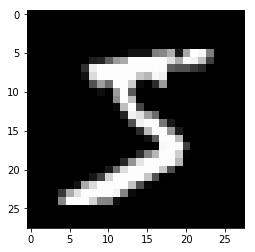

In [0]:
# 画像を表示
img = train[0][0]
plt.gray() # グレースケールの表示
plt.imshow(img.transpose(1,2,0).reshape(28,28))

### モデルの構築

今回はシンプルなネットワークで学習を行います。

In [0]:
import chainer
import chainer.functions as F
import chainer.links as L

In [0]:
class CNN(chainer.Chain):
    
    def __init__(self, n_mids, n_out=10):
        super().__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(1, 3, ksize=3, pad=1)
            self.fc1 = L.Linear(None, n_mids)
            self.fc2 = L.Linear(None, n_out)
            
    def __call__(self, x):
        h = self.conv1(x)
        h = self.fc1(h)
        return self.fc2(h)

In [0]:
# 再現性の確保
np.random.seed(0)

In [0]:
# モデルの宣言
model = L.Classifier(CNN(n_mids=100))

In [0]:
# Optimizer の定義
optimizer = chainer.optimizers.MomentumSGD()
optimizer.setup(model)

In [0]:
# Iterator の定義
batchsize = 128
train_iter = chainer.iterators.SerialIterator(train, batchsize)
valid_iter = chainer.iterators.SerialIterator(valid, batchsize, repeat=False, shuffle=False)

In [0]:
# Updater の定義
epoch = 20
updater = chainer.training.StandardUpdater(train_iter, optimizer, device=-1)

In [0]:
# Trainer の定義
trainer = chainer.training.Trainer(updater, (epoch, 'epoch'), out='result/result1')

In [0]:
# Extensions の定義
from chainer.training import extensions

trainer.extend(extensions.Evaluator(valid_iter, model, device=-1))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.observe_lr())
trainer.extend(extensions.PrintReport(['epoch',  'elapsed_time', 'main/loss', 'validation/main/loss','main/accuracy', 'validation/main/accuracy', 'lr']))

In [0]:
trainer.run()

epoch       elapsed_time  main/loss   validation/main/loss  main/accuracy  validation/main/accuracy
1           8.24138       0.382281    0.30079               0.88736        0.914656                  
2           15.5793       0.303284    0.287084              0.913513       0.918513                  
3           23.4539       0.291399    0.280956              0.918094       0.919304                  
4           31.6198       0.284973    0.282258              0.919688       0.921282                  
5           39.6521       0.279567    0.278973              0.921908       0.923457                  
6           47.7481       0.276158    0.284074              0.922675       0.920194                  
7           55.6038       0.274972    0.274086              0.922958       0.924051                  
8           64.0174       0.269524    0.272165              0.925114       0.922765                  
9           71.7862       0.267383    0.274952              0.92574        0.922864 

学習中に ChaienrUI を確認すると、訓練が下記のように進んでいることをリアルタイムで確認できます。

![訓練の結果を確認](images/15/02.png)

## ChainerUI で実験内容を管理

ここからは下記のような発展的な内容を紹介します。  

- 訓練の設定の表示
- 複数の訓練結果の表示
- 訓練中のスナップショットの作成
- 訓練中の学習係数の変更

### 訓練の設定を表示

実験時には、訓練やモデルについて様々な条件、設定、ハイパーパラメータを試すことになります。それらの値を忘れず毎回保存しておくことで、ChainerUI 上で訓練の結果とともに閲覧することができます。

設定を以下のように辞書型に格納して保存しておきましょう。  

この定義した辞書は `from chainerui.utils import save_args` で保存することが可能です。   
`save_args(辞書, 保存先)` と指定すれば保存が実行されます。   


※今回はそれぞれの値を直接ノートブック上に記述していますが、コマンドラインからスクリプトを実行する場合には、実行時に引数を設定できます。こちらの [GitHub](https://github.com/chainer/chainerui/blob/master/examples/train_mnist.py) のコード例を参照してください。  

In [0]:
# 引数の定義
args = {
    "batchsize":128,
    "epoch":20,
    "frequency":1,
    "resume":'',
    "gpu":-1,
    "out":'result/result2',
    "unit":50
}

In [0]:
# 'result/result2' に保存
import chainerui
from chainerui.utils import save_args
save_args(args, out_path=args["out"])

In [0]:
# 再現性の確保
np.random.seed(0)

In [0]:
# モデルの宣言
model = L.Classifier(CNN(n_mids=args["unit"]))

In [0]:
# Optimizer の定義
optimizer = chainer.optimizers.MomentumSGD()
optimizer.setup(model)

In [0]:
# Iterator の定義
train_iter = chainer.iterators.SerialIterator(train, args["batchsize"])
valid_iter = chainer.iterators.SerialIterator(valid, args["batchsize"], repeat=False, shuffle=False)

In [0]:
# Updater の定義
updater = chainer.training.StandardUpdater(train_iter, optimizer, device=args["gpu"])

### 複数の訓練結果を表示

複数の訓練結果を表示したい場合には、プロジェクトの階層の下に個別のディレクトリを作成してください。それぞれの訓練結果のログ（ファイル名 `log`）をまとめて表示することができます。

例えば、先ほど訓練結果の出力先ディレクトリである `args.out` を `'result/result1'` や `'result/result2'` と指定しました。
すると、下記のようなディレクトリ構造になっており、ChainerUI では `result/result1/log` と `result/result2/log` の両方から訓練結果を読み出して表示することができます。


```bash
作業ディレクトリ ─ Untitled.ipynb
     　　　　└─  result
         　   　　　└─  result1 ─ log
         　　   　　└─  result2 ─ log
```

In [0]:
# Trainer の定義
trainer = chainer.training.Trainer(updater, (args["epoch"], 'epoch'), out=args["out"])

### 訓練中のスナップショットの作成・訓練中の学習係数の変更

ChainerUI では、訓練中にコマンドを送ることで、訓練途中でスナップショットの作成や学習係数の変更を実行できます。
そのための準備として `CommandsExtension` を `Trainer` に加えておく必要があります。以下のように新たにインポートした上で追加してください。  

In [0]:
# Extensions の設定
from chainer.training import extensions
from chainerui.extensions import CommandsExtension # import

trainer.extend(extensions.Evaluator(valid_iter, model, device=args["gpu"]))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.observe_lr())
trainer.extend(extensions.PrintReport(['epoch',  'elapsed_time', 'main/loss', 'validation/main/loss','main/accuracy', 'validation/main/accuracy', 'lr']))
trainer.extend(CommandsExtension()) # 追加の extension

In [0]:
trainer.run()

epoch       elapsed_time  main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  lr        
1           12.7307       0.395813    0.227823              0.878432       0.933445                  0.01        
2           24.6422       0.205251    0.161081              0.93745        0.951345                  0.01        
3           36.3841       0.159259    0.148835              0.950926       0.952235                  0.01        
4           47.8973       0.13901     0.11666               0.9586         0.962322                  0.01        
5           58.7803       0.130257    0.115089              0.960904       0.963113                  0.01        
6           69.9611       0.124067    0.119879              0.961904       0.960938                  0.01        
7           80.7816       0.121443    0.109913              0.96257        0.96341                   0.01        
8           91.5325       0.11758     0.105396              0.964627       0.967563       

訓練を開始したら、ChainerUI の画面を確認して、上記の設定がうまく適用されているか確認しましょう。  

### ChainerUI の画面確認

現在 ChainerUI の画面では下記の画像のように表示されています。  

![](images/15/03.png)

グラフの赤色の線が前回の訓練結果、水色の線が今回の訓練結果を表しています。
また、`last log` の部分の右に `args` という欄では訓練に使用した引数を確認できます。


最後に、スナップショットの作成方法や学習係数の変更方法を確認しましょう。 


**スナップショットの作成**

スナップショットの作成は、下記の画面の通りに操作を行うと実行できます。  

![](images/15/04.png)


**学習係数の変更**  

上記の画面内にある `Detail` と表記されたボタンをクリックすると、さらに詳細な設定を行うことができます。  

`Adjust hyperparameters` の各欄を設定し `Adjust` ボタンを押すことで、学習係数を変更できます。  

![](images/15/05.png)

これまでが ChainerUI の主な使用方法になります。  
実験の内容をわかりやすく視覚化できる ChainerUI は使いこなせると大変便利です。  

次章では `ONNX` と呼ばれる、訓練済みモデルを他のプログラミング言語やフレームワークに移転して活用する場合の方法についてお伝えします。